In [69]:
#Google Mobility Report Data

#Import libraries 
import pandas as pd
import pymongo 
import matplotlib.pyplot as plt
import holidays
from pysyncon import Dataprep, Synth
from pysyncon.utils import PlaceboTest


In [70]:
#Connect to mongoDB 
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client['MobilityReports'] 
collection = db['Spain']

#Cities
ciudades = ['Zaragoza', 'Madrid', 'Barcelona', 'Valencia', 'Sevilla']
# Define la proyección para los campos que deseas obtener
proyeccion = {'date': 1, 'sub_region_2':1,'workplaces_percent_change_from_baseline': 1, '_id': 0}

#Población 

ciudades_1 = ['08019 Barcelona', '28079 Madrid', '41091 Sevilla', '46250 València', '50297 Zaragoza']

# Define la proyección para los campos que deseas obtener
proyeccion_1 = {'Municipios': 1, 'Sexo':1,'Edad': 1, 'Periodo':1, 'Total': 1, '_id':0}


#Search query
query = {'sub_region_2': {'$in': ciudades}}
data = collection.find(query, proyeccion)

# Convierte los resultados en una lista de diccionarios
datos = list(data)

# Crea un DataFrame de pandas a partir de la lista de diccionarios
df = pd.DataFrame(datos)

# Convertir la columna "Fecha" a tipo datetime
df['date'] = pd.to_datetime(df['date'])

#print (df)

# Realiza la consulta en la segunda colección
collection2 = db['poblacion_municipios']  
query2 = {'Municipios': {'$in': ciudades_1}, 'Edad (grupos quinquenales)': 'Todas las edades'}  
resultados2 = collection2.find(query2,proyeccion_1)
df2 = pd.DataFrame(list(resultados2))


df2['Municipios1'] = df2['Municipios'].str.split(' ', 1).str[1]
df2.drop('Municipios', axis=1, inplace=True)

df = df.rename(columns={'sub_region_2': 'Municipios'})
df = df.rename(columns={'workplaces_percent_change_from_baseline': 'percent_variation'})
df2 = df2.rename(columns={'Municipios1': 'Municipios'})


# Supongamos que tienes dos DataFrames: df_diario y df_anual

# 1. Crea una nueva columna en df_anual con el año a partir de la columna de fecha en formato anual
# Función para extraer el año a partir del string
def year(fecha_str):
    # Separa la cadena por espacios y extrae el año
    partes = fecha_str.split()
    if len(partes) >= 4:
        año = int(partes[-1])
        return pd.to_datetime(f'{año}-01-01')  # Devuelve el 1 de enero del año como objeto datetime
    else:
        return None

# Aplicar la función para obtener el año y crear una nueva columna "year" en df_anual
df2['year'] = df2['Periodo'].apply(year)

print(df)

print(df2)


     Municipios       date  percent_variation
0      Zaragoza 2020-02-15                  1
1      Zaragoza 2020-02-16                 -2
2      Zaragoza 2020-02-17                  4
3      Zaragoza 2020-02-18                  5
4      Zaragoza 2020-02-19                  4
...         ...        ...                ...
2917   Valencia 2022-10-11                -13
2918   Valencia 2022-10-12                -74
2919   Valencia 2022-10-13                -11
2920   Valencia 2022-10-14                -10
2921   Valencia 2022-10-15                 -3

[2922 rows x 3 columns]
        Sexo             Periodo      Total Municipios       year
0      Total  1 de enero de 2022  1.636.193  Barcelona 2022-01-01
1      Total  1 de enero de 2021  1.636.732  Barcelona 2021-01-01
2      Total  1 de enero de 2020  1.664.182  Barcelona 2020-01-01
3      Total  1 de enero de 2019  1.636.762  Barcelona 2019-01-01
4      Total  1 de enero de 2018  1.620.343  Barcelona 2018-01-01
..       ...               

C:\Users\34645\AppData\Local\Temp\ipykernel_23908\2835640444.py:41: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df2['Municipios1'] = df2['Municipios'].str.split(' ', 1).str[1]


In [71]:
#Unimos los dataframes en uno

#Por el moment, filtro para que no haya distinccion entre géneros
df2 = df2[df2['Sexo'] == 'Total']

# Convertir la columna 'date' de df1 al formato de año para que coincida con df2
df['year'] = df['date'].dt.strftime('%Y')
df2['year'] = df2['year'].dt.strftime('%Y')


# Fusionar ambos DataFrames en función de las columnas 'Municipios' y 'year' y rellenar los valores nulos
result = df.merge(df2[['Municipios', 'year', 'Total']], on=['Municipios', 'year'], how='left').fillna(method='ffill')

# Eliminar columnas innecesarias
#result = result.drop(columns=['year'])

print(result)


     Municipios       date  percent_variation  year      Total
0      Zaragoza 2020-02-15                  1  2020    681.877
1      Zaragoza 2020-02-16                 -2  2020    681.877
2      Zaragoza 2020-02-17                  4  2020    681.877
3      Zaragoza 2020-02-18                  5  2020    681.877
4      Zaragoza 2020-02-19                  4  2020    681.877
...         ...        ...                ...   ...        ...
2917   Valencia 2022-10-11                -13  2022  1.636.193
2918   Valencia 2022-10-12                -74  2022  1.636.193
2919   Valencia 2022-10-13                -11  2022  1.636.193
2920   Valencia 2022-10-14                -10  2022  1.636.193
2921   Valencia 2022-10-15                 -3  2022  1.636.193

[2922 rows x 5 columns]


In [92]:

# Convertir la columna "Fecha" a tipo datetime
result['date'] = pd.to_datetime(result['date'])

# Filtrar los días que no son fin de semana (lunes a viernes)
result = result[result['date'].dt.dayofweek < 5]

festivos = holidays.Spain(years=result['date'].dt.year.unique())
festivos_espana = [fecha.strftime('%Y-%m-%d') for fecha in festivos.keys()]

# Filtrar el DataFrame para mantener solo los días que son festivos
df_clean = result[~result['date'].dt.strftime('%Y-%m-%d').isin(festivos_espana)]


# Configurar el índice del DataFrame como la columna de fechas
df_clean.set_index('date', inplace=True)

# Crea una nueva columna llamada "ID" con valores incrementales de uno en uno.
df_clean['ID'] = range(1, len(df_clean) + 1)

# Encuentra el valor máximo actual de la columna "ID".
max_id = df_clean['ID'].max()

# Define el valor en el que deseas reiniciar el "ID" (970 en este caso).
reset_value = 970

# Reinicia la columna "ID" cuando llega al valor deseado.
df_clean['ID'] = df_clean['ID'].apply(lambda x: x if x <= reset_value else 1 + (x - reset_value))

# Ahora, el DataFrame "df_clean" tendrá una nueva columna "ID" con valores incrementales que se reiniciarán cuando lleguen a 970.
print(df_clean)

           Municipios  percent_variation  year      Total    ID
date                                                           
2020-02-17   Zaragoza                  4  2020    681.877     1
2020-02-18   Zaragoza                  5  2020    681.877     2
2020-02-19   Zaragoza                  4  2020    681.877     3
2020-02-20   Zaragoza                  3  2020    681.877     4
2020-02-21   Zaragoza                  2  2020    681.877     5
...               ...                ...   ...        ...   ...
2022-10-07   Valencia                 -9  2022  1.636.193  1064
2022-10-10   Valencia                -13  2022  1.636.193  1065
2022-10-11   Valencia                -13  2022  1.636.193  1066
2022-10-13   Valencia                -11  2022  1.636.193  1067
2022-10-14   Valencia                -10  2022  1.636.193  1068

[2037 rows x 5 columns]


C:\Users\34645\AppData\Local\Temp\ipykernel_23908\2130640628.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ID'] = range(1, len(df_clean) + 1)
C:\Users\34645\AppData\Local\Temp\ipykernel_23908\2130640628.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ID'] = df_clean['ID'].apply(lambda x: x if x <= reset_value else 1 + (x - reset_value))


           Municipios  percent_variation  year      Total    ID
date                                                           
2020-02-17   Zaragoza                  4  2020    681.877     1
2020-02-18   Zaragoza                  5  2020    681.877     2
2020-02-19   Zaragoza                  4  2020    681.877     3
2020-02-20   Zaragoza                  3  2020    681.877     4
2020-02-21   Zaragoza                  2  2020    681.877     5
...               ...                ...   ...        ...   ...
2022-10-07   Valencia                 -9  2022  1.636.193  1064
2022-10-10   Valencia                -13  2022  1.636.193  1065
2022-10-11   Valencia                -13  2022  1.636.193  1066
2022-10-13   Valencia                -11  2022  1.636.193  1067
2022-10-14   Valencia                -10  2022  1.636.193  1068

[2037 rows x 5 columns]


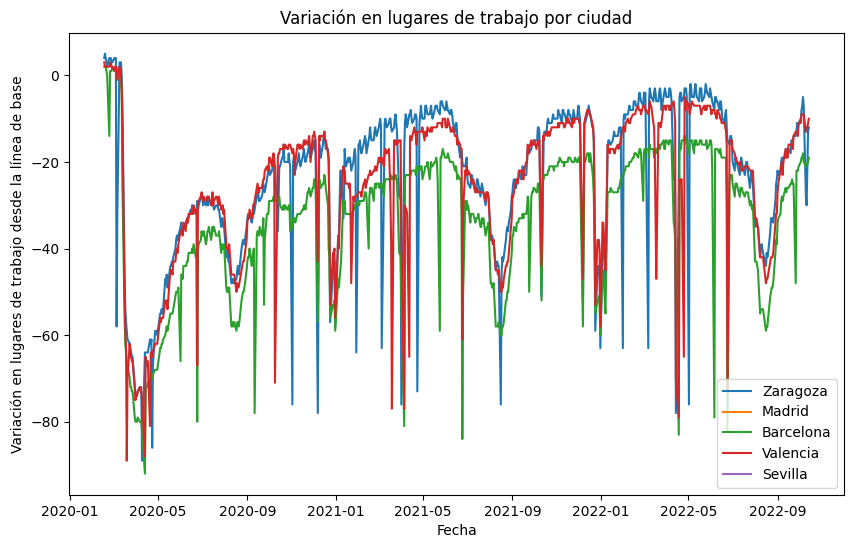

In [95]:
#Print DF and time series

print(df_clean)

# Configura el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Dibuja una serie temporal para cada ciudad
for ciudad in ciudades:
    ciudad_data = df_clean[df_clean['Municipios'] == ciudad]['percent_variation']
    plt.plot(ciudad_data.index, ciudad_data.values, label=ciudad)

# Configura etiquetas y leyenda
plt.xlabel('Fecha')
plt.ylabel('Variación en lugares de trabajo desde la línea de base')
plt.title('Variación en lugares de trabajo por ciudad')
plt.legend()

# Muestra el gráfico
plt.show()


In [109]:
dataprep = Dataprep(
    foo=df_clean,
    predictors=[
        "Total",],
    predictors_op="mean",
    time_predictors_prior=range(26, 200),
    special_predictors=[
        ('percent_variation', range (26,200), 'mean'),
    ],
    dependent="percent_variation",
    unit_variable="Municipios",
    time_variable="ID",
    treatment_identifier="Zaragoza",
    controls_identifier=[
   "Barcelona", 
    ],
    time_optimize_ssr=range(26, 318),
)

synth = Synth()
print(synth.fit(dataprep=dataprep, optim_method="Nelder-Mead", optim_initial="equal"))

c:\Users\34645\Desktop\Doctorado_II\Códigos_Python\miproyecto\Lib\site-packages\pysyncon\dataprep.py:187: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  .agg(self.predictors_op)


None


In [110]:
print(synth.weights())

Barcelona    1.0
Name: weights, dtype: float64


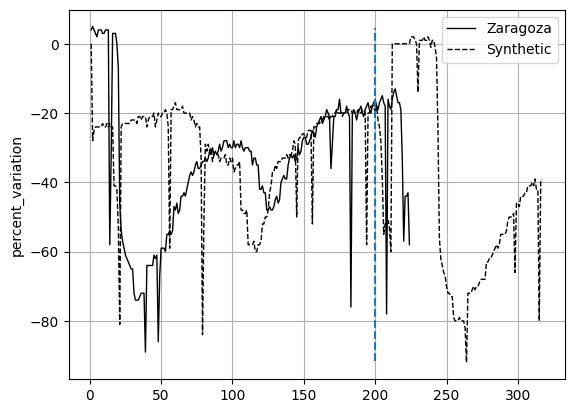

In [111]:
synth.path_plot(time_period=range(1, 318), treatment_time=200)